In [1]:
!git clone https://github.com/claudio966/tabular_rl.git
%cd tabular_rl
!python3 setup.py install
!pip install gymnasium

import sys
sys.path.append('/content/tabular_rl/build/lib')

Cloning into 'tabular_rl'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 174 (delta 106), reused 115 (delta 59), pack-reused 0
Receiving objects: 100% (174/174), 75.36 KiB | 3.59 MiB/s, done.
Resolving deltas: 100% (106/106), done.
/content/tabular_rl
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist

In [2]:
'''
Verbose canonical known-dynamics environment.
It adds a list and a dictionary for actions and states:
            self.actionDictionaryGetIndex
            self.actionListGivenIndex
            self.stateDictionaryGetIndex
            self.stateListGivenIndex
such that the output to the user can be more verbose, indicating
in the grid-world example, the labels "left", "right", "up", "down",
for instance. In the verbose case, the environment provides
the label information via the lists: stateListGivenIndex and actionListGivenIndex.
'''
import numpy as np
from random import choices, randint
import gymnasium as gym
from gymnasium import spaces
from tabular_rl import known_dynamics_env as kde

In [3]:
def createDefaultDataStructures(num, prefix) -> tuple[dict, list]:
    '''Create default data structures for actions and states.
    '''
    possibleActions = list()
    for uniqueIndex in range(num):
        possibleActions.append(prefix + str(uniqueIndex))
    dictionaryGetIndex = dict()
    listGivenIndex = list()
    for uniqueIndex in range(num):
        dictionaryGetIndex[possibleActions[uniqueIndex]] = uniqueIndex
        listGivenIndex.append(possibleActions[uniqueIndex])
    return dictionaryGetIndex, listGivenIndex


In [4]:
class VerboseKnownDynamicsEnv(kde.KnownDynamicsEnv):
    def __init__(self, nextStateProbability, rewardsTable,
                 states_info=None, actions_info=None):
        super(VerboseKnownDynamicsEnv, self).__init__(
            nextStateProbability, rewardsTable)
        # nextStateProbability, rewardsTable)
        self.__version__ = "0.1.0"
        # print("AK Finite MDP - Version {}".format(self.__version__))
        if actions_info == None:
            # initialize with default names and structures
            self.actionDictionaryGetIndex, self.actionListGivenIndex = createDefaultDataStructures(
                self.A, "A")
        else:
            self.actionDictionaryGetIndex = actions_info[0]
            self.actionListGivenIndex = actions_info[1]

        if states_info == None:
            # initialize with default names and structures
            self.stateDictionaryGetIndex, self.stateListGivenIndex = createDefaultDataStructures(
                self.S, "S")
        else:
            self.stateDictionaryGetIndex = states_info[0]
            self.stateListGivenIndex = states_info[1]

    def step(self, action: int):
        ob, reward, gameOver, history = super().step(action)
        # convert history to a more pleasant version
        s = history["state_t"]
        action = history["action_t"]
        nexts = history["state_tp1"]
        # history version with actions and states, not their indices
        history = {"time": self.currentIteration, "state_t": self.stateListGivenIndex[s], "action_t": self.actionListGivenIndex[action],
                   "reward_tp1": reward, "state_tp1": self.stateListGivenIndex[nexts]}
        return ob, reward, gameOver, history

    def pretty_print_policy(self, policy: np.ndarray):
        '''
        Print policy.
        '''
        for s in range(self.S):
            currentState = self.stateListGivenIndex[s]
            print('\ns' + str(s) + '=' + str(currentState))
            first_action = True
            for a in range(self.A):
                if policy[s, a] == 0:
                    continue
                currentAction = self.actionListGivenIndex[a]
                if first_action:
                    print(' | a' + str(a) + '=' + str(currentAction), end='')
                    first_action = False  # disable this way of printing
                else:
                    print(' or a' + str(a) + '=' + str(currentAction), end='')
        print("")

In [5]:
if __name__ == '__main__':
    print("Main Gambler's Ruin:")

    nextStateProbability = np.array([[[0, 0.3, 0.7, 0, 0],
                                      [0, 0.2, 0.8, 0, 0]],
                                         [[0, 0, 0.9, 0, 0.1],
                                          [0, 0, 0.8, 0, 0.2]],
                                         [[0, 0.4, 0, 0.6, 0],
                                          [0, 0.5, 0, 0.5, 0]],
                                         [[0, 0, 0, 1, 0],
                                          [0, 0, 0, 1, 0]],
                                        [[0, 0, 0.9, 0, 0.1],
                                         [0, 0, 0.8, 0, 0.2]]])
    rewardsTable = np.array([[[0, 10, -5, 0, 0],
                              [0, 25, -15, 0, 0]],
                                [[0, 0, -5, 0, 15],
                                 [0, 0,-15, 0, 25]],
                             [[0, 15, 0, -5, 0],
                              [0, 25, 0, -15, 0]],
                             [[0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0]],
                             [[0, 0, -5, 0, 10],
                              [0, 0, -15, 0, 25]]])


    env = VerboseKnownDynamicsEnv(nextStateProbability, rewardsTable)
    print(env.step(0))

Main Gambler's Ruin:
(2, -5, False, {'time': 1, 'state_t': 'S4', 'action_t': 'A0', 'reward_tp1': -5, 'state_tp1': 'S2'})


In [6]:
from tabular_rl import optimum_values as optimum
from tabular_rl import finite_mdp_utils as fmdp
from matplotlib import pyplot as plt
import itertools

print("Complete trajectory vector:")
episodes = 400
reward_per_episode = list()
num_steps = 200
uniform_policy = fmdp.get_uniform_policy_for_fully_connected(env.S, env.A)
taken_actions, rewards_tp1, states = fmdp.generate_trajectory(
    env, uniform_policy, num_steps)
trajectory = fmdp.format_trajectory_as_single_array(
    taken_actions, rewards_tp1, states)

state_values = optimum.compute_optimal_state_values(env)
action_values, stopping_criteria = optimum.compute_optimal_action_values(env)


Complete trajectory vector:


In [7]:
print("Interpret trajectory with print_trajectory() method:")
#fmdp.print_trajectory(trajectory)

# Show state and action values
print('State Values: ', state_values[0])
print('Action Values: ', action_values)

optimal_policy = fmdp.convert_action_values_into_policy(np.array(action_values))
# Show optimal policy
print('Optimal Policies: ', optimal_policy)

Interpret trajectory with print_trajectory() method:
State Values:  [3.66973877 1.84234647 5.82905591 0.         1.34234647]
Action Values:  [[ 3.66973877 -2.47145738]
 [ 1.84234647 -2.56145738]
 [ 3.66324473  5.82905591]
 [ 0.          0.        ]
 [ 1.34234647 -2.56145738]]
Optimal Policies:  [[1.  0. ]
 [1.  0. ]
 [0.  1. ]
 [0.5 0.5]
 [1.  0. ]]


In [8]:
discount_factor = [0.1, 0.3]
learning_rate = [0.01, 0.1]
max_episodes = [50, 60]

combinations = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
        [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]

In [9]:
def get_avg_cumsum_reward(experiment: list()) -> list():
    cumsum_reward_storage = list()
    cumsum_reward = 0
    episode_idx = 1
    for ep_reward in experiment:
        cumsum_reward = ep_reward
        cumsum_reward_storage.append(cumsum_reward / episode_idx)
        episode_idx += 1

    return cumsum_reward_storage

## Compare Q-Learning Algorithm Results with Optimal Policy Results


Method compute_optimal_action_values() converged in 52 iterations with stopping criterion= 9.382031667529512e-11

Using optimum policy, average reward= 3.75  standard deviation= 33.11627243516396
Running 1  runs of q_learning_several_episodes() with 50 episodes per run
Found better stateActionValues
run= 0 average reward= -2.1

Method compute_optimal_action_values() converged in 52 iterations with stopping criterion= 9.382031667529512e-11

Using optimum policy, average reward= 9.9  standard deviation= 34.234339485376374
Running 1  runs of q_learning_several_episodes() with 60 episodes per run
Found better stateActionValues
run= 0 average reward= -0.9166666666666666

Method compute_optimal_action_values() converged in 52 iterations with stopping criterion= 9.382031667529512e-11

Using optimum policy, average reward= 1.65  standard deviation= 22.539465388513545
Running 1  runs of q_learning_several_episodes() with 50 episodes per run
Found better stateActionValues
run= 0 average reward=

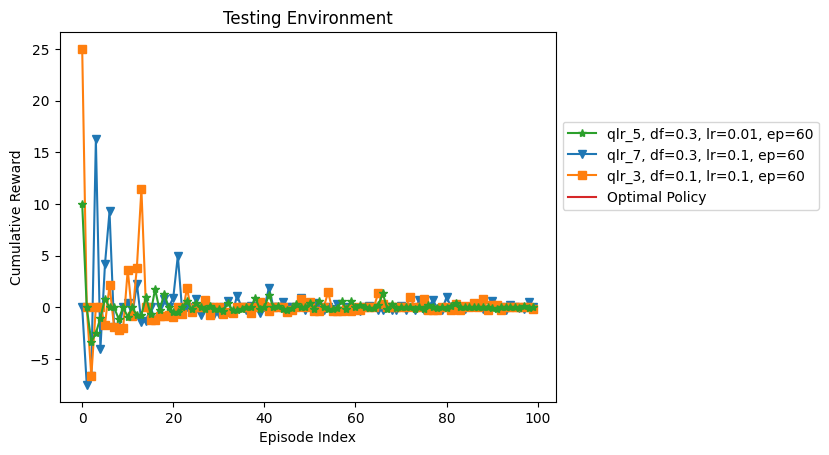

In [10]:
all_training_qlearning_rewards, all_testing_qlearning_rewards, all_optimal_rewards = list(), list(), list()
all_qlearning_labels = list()

action_values, stopping_criteria = optimum.compute_optimal_action_values(env)
optimal_policy = fmdp.convert_action_values_into_policy(np.array(action_values))

optimal_rewards = fmdp.run_several_episodes(env, optimal_policy,
                                        max_num_time_steps_per_episode=100,
                                        num_episodes=100)

avg_cumsum_optimal_reward = get_avg_cumsum_reward(optimal_rewards)


experiment_id = 0
for combination in combinations:
    chosen_discount_factor = discount_factor[combination[0]]
    chosen_learning_rate = learning_rate[combination[1]]
    chosen_max_train_episodes = max_episodes[combination[2]]
    _, training_qlearning_rewards, testing_qlearning_rewards = optimum.compare_q_learning_with_optimum_policy(env,
                                                                                    num_train_episodes=chosen_max_train_episodes,
                                                                                    num_test_episodes=100,
                                                                                    learning_rate=chosen_learning_rate,
                                                                                    explorationProbEpsilon=chosen_discount_factor,
                                                                                    debug_mode=False)

    all_training_qlearning_rewards.append(training_qlearning_rewards)

    all_testing_qlearning_rewards.append(testing_qlearning_rewards)
    all_qlearning_labels.append(
        f'qlr_{experiment_id}, df={chosen_discount_factor}, lr={chosen_learning_rate}, ep={chosen_max_train_episodes}')

    experiment_id += 1

all_cumsum_testing_qlearning = list()
for experiment in all_testing_qlearning_rewards:
    all_cumsum_testing_qlearning.append(get_avg_cumsum_reward(experiment))


# enumerate the best experiments
avg_qlearning_reward = [np.mean(x) for x in all_testing_qlearning_rewards]
avg_optimal_reward = [np.mean(x) for x in all_optimal_rewards]
best_experiments = np.flip(np.argsort(avg_qlearning_reward))

# Plot markers
marker = ['v', 's', '*']
marker_id = 0

for experiment_id in list(best_experiments[0:3]):
    plt.plot(all_cumsum_testing_qlearning[experiment_id], marker=marker[marker_id], label=all_qlearning_labels[experiment_id])

    marker_id += 1

# Plot average cumulative reward of optimal policy
plt.plot(avg_optimal_reward, label='Optimal Policy')

handles, labels = plt.gca().get_legend_handles_labels()

# Adjust legend order
last_row = [all_cumsum_testing_qlearning[i][-1] for i in best_experiments[0:3]] + [np.cumsum(optimal_rewards)[-1]]
order = np.argsort(last_row)
order = np.flip(order)

print(last_row)
print(order)
print(handles)

plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='lower left', bbox_to_anchor=(1, 0.5))

plt.title('Testing Environment')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode Index')
plt.savefig('Testing_environment', dpi=500)
plt.show()


## Q-learning training convergence

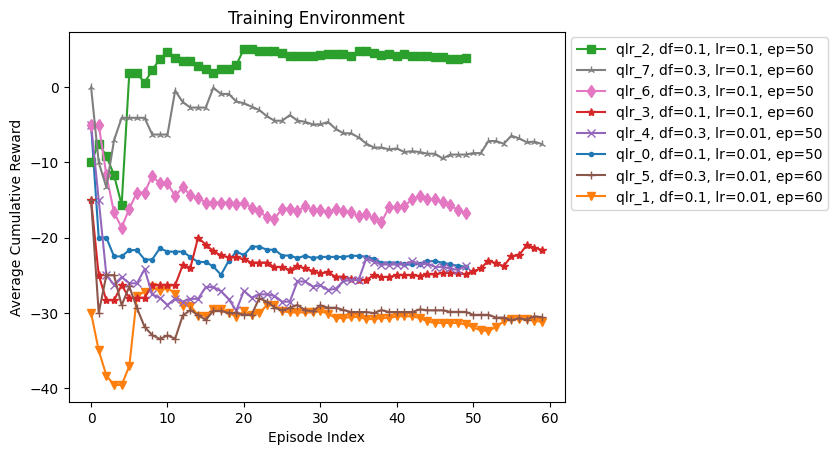

In [11]:
experiment_id = 0
marker = ['.', 'v', 's', '*', 'x', '+', 'd', '2']

all_cumsum_training_qlearning = list()
for experiment in all_training_qlearning_rewards:
    cumsum_reward_storage = list()
    cumsum_reward = 0
    episode_idx = 1
    for ep_reward in experiment:
        cumsum_reward = ep_reward
        cumsum_reward_storage.append(cumsum_reward / episode_idx)
        episode_idx +=1
    all_cumsum_training_qlearning.append(cumsum_reward_storage)
    plt.plot(np.cumsum(cumsum_reward_storage), marker=marker[experiment_id], label=all_qlearning_labels[experiment_id])
    experiment_id += 1
handles, labels = plt.gca().get_legend_handles_labels()

# Adjust legend order
last_row = [np.cumsum(all_cumsum_training_qlearning[i])[-1] for i in range(len(all_training_qlearning_rewards))]
order = np.argsort(last_row)
order = np.flip(order)

plt.title('Training Environment')
plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='lower left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Episode Index')
plt.ylabel('Average Cumulative Reward')
plt.savefig('Training_environment', dpi=500)
plt.show()